In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
import pickle

In [2]:
with open('initial_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [3]:
model.booster_.feature_name()

['Receiving_Currency_Australian_Dollar',
 'Receiving_Currency_Bitcoin',
 'Receiving_Currency_Brazil_Real',
 'Receiving_Currency_Canadian_Dollar',
 'Receiving_Currency_Euro',
 'Receiving_Currency_Mexican_Peso',
 'Receiving_Currency_Ruble',
 'Receiving_Currency_Rupee',
 'Receiving_Currency_Saudi_Riyal',
 'Receiving_Currency_Shekel',
 'Receiving_Currency_Swiss_Franc',
 'Receiving_Currency_UK_Pound',
 'Receiving_Currency_US_Dollar',
 'Receiving_Currency_Yen',
 'Receiving_Currency_Yuan',
 'Payment_Currency_Australian_Dollar',
 'Payment_Currency_Bitcoin',
 'Payment_Currency_Brazil_Real',
 'Payment_Currency_Canadian_Dollar',
 'Payment_Currency_Euro',
 'Payment_Currency_Mexican_Peso',
 'Payment_Currency_Ruble',
 'Payment_Currency_Rupee',
 'Payment_Currency_Saudi_Riyal',
 'Payment_Currency_Shekel',
 'Payment_Currency_Swiss_Franc',
 'Payment_Currency_UK_Pound',
 'Payment_Currency_US_Dollar',
 'Payment_Currency_Yen',
 'Payment_Currency_Yuan',
 'Payment_Format_ACH',
 'Payment_Format_Bitcoin',
 'Pa

In [ ]:
df = pd.read_csv("LI-Small_Trans.csv", header=0)

In [ ]:
#### For preprocess.py

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Add column for Unix time
df['unix_timestamp'] = (df['Timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Add column for day of the week (0: Monday, 1: Tuesday, ..., 6: Sunday)
df['day_of_week'] = df['Timestamp'].dt.dayofweek


def create_currency_symbol_dict():
    currencies = [
        'Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro',
        'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel',
        'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan'
    ]

    symbols = [
        'AUD', 'BTC', 'BRL', 'CAD', 'EUR',
        'MXN', 'RUB', 'INR', 'SAR', 'ILS',
        'CHF', 'GBP', 'USD', 'JPY', 'CNY'
    ]

    return dict(zip(currencies, symbols))

currency_symbol_dict = create_currency_symbol_dict()
print(currency_symbol_dict)

df['receiving_currency_symbol'] = df['Receiving Currency'].map(currency_symbol_dict)
df['paid_currency_symbol'] = df['Payment Currency'].map(currency_symbol_dict)

from currency_converter import CurrencyConverter
c = CurrencyConverter()

btc_to_usd_rate = 19804.78  # 1 BTC = $19,804.78
sar_to_usd_rate = 0.2653 # 1 SAR = $0.2653

# Function to convert amount to USD
def convert_to_usd(amount, currency):
    if currency == 'BTC':
        return amount * btc_to_usd_rate
    elif currency == 'SAR':
        return amount * sar_to_usd_rate
    else:
        return c.convert(amount, currency, 'USD')


# Add columns for normalized received and paid amounts in USD
df['normalized_received_amount'] = df.apply(lambda row: convert_to_usd(row['Amount Received'], row['receiving_currency_symbol']), axis=1)
df['normalized_paid_amount'] = df.apply(lambda row: convert_to_usd(row['Amount Paid'], row['paid_currency_symbol']), axis=1)

df['unix_timestamp'] = (df['Timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df[['unix_timestamp', 'sender_uid', 'receiver_uid', 'normalized_received_amount', 'normalized_paid_amount']].to_csv('predicted.csv', index=False, header=False, sep= " ")


In [ ]:
# check for missing data

df.isnull().mean()

In [ ]:
df['Is Laundering'].value_counts(normalize=True)

In [ ]:
df['Payment Format'].value_counts()

### Model Preprocessing 

#### Data preparation

**Missing data:** No missing values found

**Extract** day / hour / minutes out of timestamp variable (since the only month is september 2022)

**Renaming** columns for a better understanding

#### Categorical Data Encoding

**OneHotEncoding:** Receiving Currency, Payment Currency, Payment format

**TargetEncoding:** From Bank, To Bank, Account Sent, Account Received

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract days, hours, and minutes
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['day_of_week'] = df['Timestamp'].dt.dayofweek

# df = df.drop(columns=['Timestamp'])

In [ ]:
# Renaming columns
df.rename(columns={'Account': 'Sender', 'Account.1': 'Receiver'}, inplace=True)

In [ ]:
df['sender_uid'] = df['From Bank'].astype(str) + df['Sender'].astype(str)
df['receiver_uid'] = df['To Bank'].astype(str) + df['Receiver'].astype(str)
df = df.drop(columns=['Sender', 'Receiver'])
df

In [ ]:
# from category_encoders import TargetEncoder, CatBoostEncoder

# Splitting data into train, validation, and test sets (60/20/20)
train_data, test_data = train_test_split(X, test_size=0.2, random_state=12)
# train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=12)

# Define the features and target variable
X_train = train_data.drop(columns=['Is Laundering'])
y_train = train_data['Is Laundering']
# X_val = val_data.drop(columns=['Is Laundering'])
# y_val = val_data['Is Laundering']
X_test = test_data.drop(columns=['Is Laundering'])
y_test = test_data['Is Laundering']

# Define the categorical columns
categorical_cols = ['Receiving Currency', 'Payment Currency', 'Payment Format', 'From Bank', 'To Bank', 'sender_uid', 'receiver_uid', 'Pattern']

# Create ColumnTransformer for encoding categorical data
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False), ['Receiving Currency', 'Payment Currency', 'Payment Format','Pattern']),
        ('target', TargetEncoder(), ['From Bank', 'To Bank', 'sender_uid', 'receiver_uid'])
    ],
    remainder='passthrough'
)

column_transformer.set_output(transform='pandas')

# Fit and transform the ColumnTransformer on the training data
X_train_encoded = column_transformer.fit_transform(X_train, y_train)
# column_transformer.fit(X_train, y_train)
# df_encoded = column_transformer.transform(df)
# Transform the validation and test data using the fitted encoder
# X_val_encoded = column_transformer.transform(X_val)
X_test_encoded = column_transformer.transform(X_test)

with open('column_transformer2.pkl', 'wb') as file:
    pickle.dump(column_transformer, file)

In [ ]:
import pickle 

with open('column_transformer.pkl', 'rb') as file:
   column_transformer = pickle.load(file)

In [ ]:
# Remove prefixes from column transformer
def remove_prefixes(data):
    prefixes = ['onehot__', 'target__', 'remainder__']
    for prefix in prefixes:
        data.columns = [col.replace(prefix, '') for col in data.columns]

    return data

In [ ]:
X_train_encoded = remove_prefixes(X_train_encoded)
X_val_encoded = remove_prefixes(X_val_encoded)
X_test_encoded = remove_prefixes(X_test_encoded)

# df_encoded = remove_prefixes(df_encoded)

In [ ]:
# Define Evaluation Metrics
def evaluate(y_true, y_prob):
    # Convert probabilities to binary predictions using a threshold
    threshold = 0.5
    y_pred = (y_prob >= threshold).astype(int)
    
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return auc, f1, precision, recall

# Define the hyperopt Objective Function
def objective(params):
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train_encoded, y_train)
    y_prob_train = clf.predict_proba(X_train_encoded)[:, 1]
    y_prob_val = clf.predict_proba(X_val_encoded)[:, 1]
    auc_train, f1_train, precision_train, recall_train = evaluate(y_train, y_prob_train)
    auc_val, f1_val, precision_val, recall_val = evaluate(y_val, y_prob_val)
    
    with open("parameter_tuning.txt", "a") as f:
        f.write("="*50 + "\n")
        f.write("Hyperparameters:\n")
        f.write(str(params) + "\n")
        f.write("Train Metrics:\n")
        f.write(f"AUC Train: {auc_train}\n")
        f.write(f"F1 Score Train: {f1_train}\n")
        f.write(f"Precision Train: {precision_train}\n")
        f.write(f"Recall Train: {recall_train}\n")
        f.write("Validation Metrics:\n")
        f.write(f"AUC Validation: {auc_val}\n")
        f.write(f"F1 Score Validation: {f1_val}\n")
        f.write(f"Precision Validation: {precision_val}\n")
        f.write(f"Recall Validation: {recall_val}\n")

    return {'loss': -auc_val, 'status': STATUS_OK}

# Define Hyperparameter Space
space = {
    'n_estimators': hp.choice('n_estimators', [300, 500, 700]),
    'max_depth': hp.choice('max_depth', [3, 5, 7]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'verbose': [-1],
    'random_state': [12]
}

# Run Hyperparameter Optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Evaluate on Test Set and Write to Text File
best_params = space_eval(space, best)
with open("parameter_tuning.txt", "a") as f:
    f.write("="*50 + "\n")
    f.write("Best Hyperparameters:\n")
    f.write(str(best_params) + "\n")

clf_best = lgb.LGBMClassifier(**best_params)
clf_best.fit(X_train_encoded, y_train)
y_prob_test = clf_best.predict_proba(X_test_encoded)[:, 1]
auc_test, f1_test, precision_test, recall_test = evaluate(y_test, y_prob_test)

with open("parameter_tuning.txt", "a") as f:
    f.write("="*50 + "\n")
    f.write("Test Metrics:\n")
    f.write(f"AUC Test: {auc_test}\n")
    f.write(f"F1 Score Test: {f1_test}\n")
    f.write(f"Precision Test: {precision_test}\n")
    f.write(f"Recall Test: {recall_test}\n")

#### **Best Initial Hyperparameter combination**: learing rate = 0.01, n_estimators = 500, max_depth = 5

In [ ]:
### Continue tuning


def evaluate(y_true, y_prob):
    threshold = 0.5 
    y_pred = (y_prob >= threshold).astype(int)
    
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return auc, f1, precision, recall

def objective(params):
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train_encoded, y_train)
    y_prob_train = clf.predict_proba(X_train_encoded)[:, 1]
    y_prob_val = clf.predict_proba(X_val_encoded)[:, 1]
    auc_train, f1_train, precision_train, recall_train = evaluate(y_train, y_prob_train)
    auc_val, f1_val, precision_val, recall_val = evaluate(y_val, y_prob_val)
    
    with open("paramter_tuning.txt", "a") as f:
        f.write("="*50 + "\n")
        f.write("Hyperparameters:\n")
        f.write(str(params) + "\n")
        f.write("Train Metrics:\n")
        f.write(f"AUC Train: {auc_train}\n")
        f.write(f"F1 Score Train: {f1_train}\n")
        f.write(f"Precision Train: {precision_train}\n")
        f.write(f"Recall Train: {recall_train}\n")
        f.write("Validation Metrics:\n")
        f.write(f"AUC Validation: {auc_val}\n")
        f.write(f"F1 Score Validation: {f1_val}\n")
        f.write(f"Precision Validation: {precision_val}\n")
        f.write(f"Recall Validation: {recall_val}\n")

    return {'loss': -auc_val, 'status': STATUS_OK}

space = {
    'n_estimators': hp.choice('n_estimators', [500]),
    'max_depth': hp.choice('max_depth', [5]),
    'learning_rate': hp.choice('learning_rate', [0.01]),
    'num_leaves': hp.uniformint('num_leaves', 15, 31),
    'min_data_in_leaf': hp.uniformint('min_data_in_leaf', 20, 200),
    'verbose': hp.choice('verbose',[-1]),
    'random_state': hp.choice('random_state',[12])
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

best_params = space_eval(space, best)
with open("paramter_tuning.txt", "a") as f:
    f.write("="*50 + "\n")
    f.write("Best Hyperparameters:\n")
    f.write(str(best_params) + "\n")

clf_best = lgb.LGBMClassifier(**best_params)
clf_best.fit(X_train_encoded, y_train)
y_prob_test = clf_best.predict_proba(X_test_encoded)[:, 1]
auc_test, f1_test, precision_test, recall_test = evaluate(y_test, y_prob_test)

with open("paramter_tuning.txt", "a") as f:
    f.write("="*50 + "\n")
    f.write("Test Metrics:\n")
    f.write(f"AUC Test: {auc_test}\n")
    f.write(f"F1 Score Test: {f1_test}\n")
    f.write(f"Precision Test: {precision_test}\n")
    f.write(f"Recall Test: {recall_test}\n")

#### **After tuning for num_leaves / min data in leaf**: num leaves high -> between 25 and 31 || min data in leaf -> a bit higher than default: > 100  

In [ ]:
clf = lgb.LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=500, num_leaves=31, min_data_in_leaf=120, verbose=-1, random_state=12)

In [ ]:
clf.fit(X_train_encoded, y_train)

LGBMClassifier(learning_rate=0.01, max_depth=5, min_data_in_leaf=120,
               n_estimators=500, random_state=12, verbose=-1)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Get predicted probabilities on training data
y_prob_train = clf.predict_proba(X_train)[:, 1]
y_prob_test = clf.predict_proba(X_test)[:, 1]

# Initialize variables to store the optimal threshold and corresponding F1 score
optimal_threshold = 0
optimal_f1_score = 0

# Iterate through different threshold values
thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    # Convert probabilities to binary predictions using the current threshold
    y_pred_train = (y_prob_train >= threshold).astype(int)
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    # Calculate F1 score for train data
    train_f1 = f1_score(y_train, y_pred_train)
    
    # Print performance metrics for train data
    print(f"Threshold: {threshold:.2f}")
    print(f"F1 Score: {train_f1:.4f}")
    print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_train, y_prob_train):.4f}")
    print()
    
    # Check if the current F1 score is higher than the optimal F1 score
    if train_f1 > optimal_f1_score:
        optimal_f1_score = train_f1
        optimal_threshold = threshold

# Print the optimal threshold
print("Optimal Threshold:", optimal_threshold)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

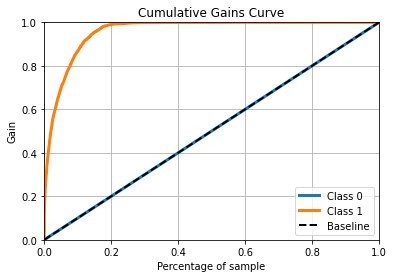

In [ ]:
skplt.metrics.plot_cumulative_gain(y, y_proba)

# print(y.shape, y_proba.shape)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


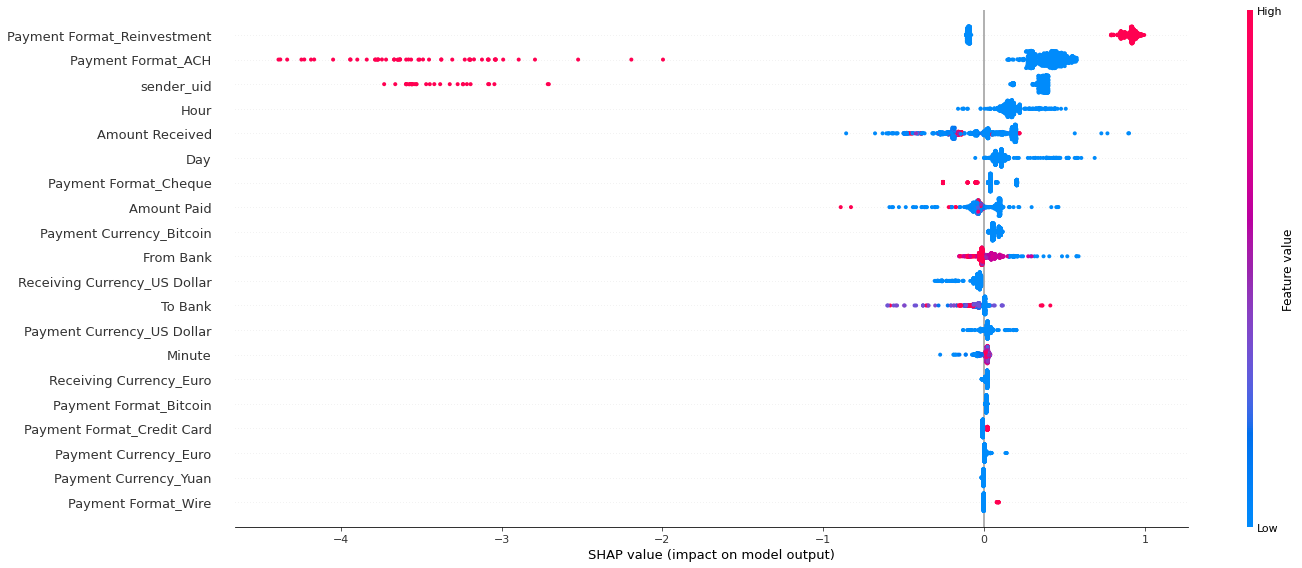

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X[[col for col in X.columns if col != 'Timestamp']].iloc[:1000])

# Generate the summary plot
shap.summary_plot(shap_values[0], X[[col for col in X.columns if col != 'Timestamp']].iloc[:1000], plot_size=[20,8])
plt.show()